## **Abstract**
In this project, I work on predicting heart disease using machine learning. In Part 1, I try to reproduce the results from a published study that uses a stacking ensemble approach. I implement the same classifiers—Logistic Regression, Decision Tree, Random Forest, XGBoost, KNN, Naive Bayes, and the Stacking Ensemble—following the described preprocessing steps, train/test split, and evaluation metrics. Where model details are missing, I make justified assumptions and explain any variations in the results.
In Part 2, I develop my own machine learning solution that differs meaningfully from the article. I apply a novel feature selection strategy combining causal discovery and stability selection, along with a customized modeling pipeline. My goal is to improve generalization, interpretability, and performance compared to the original method.

### **Loading Necessary Libraries**

In [ ]:
# Data Handling
import pandas as pd
import numpy as np
from collections import Counter

# Preprocessing
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.utils import resample

# Feature Selection
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.inspection import permutation_importance

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, auc, matthews_corrcoef
)
from sklearn.exceptions import NotFittedError

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Causal Discovery (causal-learn)
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.utils.cit import fisherz


### **Loading and Preparing the Heart Disease Dataset**

I load the heart disease dataset from four files—Cleveland, Hungarian, Switzerland, and VA—sourced from the UCI Machine Learning Repository ([link](https://archive.ics.uci.edu/dataset/45/heart+disease)). To ensure data integrity, I chose to use the cleaner UCI version, which contains 920 rows after combining all four sources.
I selected the same features as mentioned in the research paper. I then converted the multi-class `target` variable into a binary format, where `0` indicates no heart disease and any other value is mapped to `1`, representing presence of heart disease. This preprocessing ensures consistency with the experimental setup in the original study and prepares the dataset for binary classification.


In [ ]:
# List of processed data files
file_paths = [
    "processed.cleveland.data",
    "processed.hungarian.data",
    "processed.switzerland.data",
    "processed.va.data"
]

# Column names as per heart-disease.names file (UCI documentation)
columns = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach",
    "exang", "oldpeak", "slope", "ca", "thal", "target"
]

# Load and combine all processed data files
df_list = []
for file in file_paths:
    df = pd.read_csv(file, header=None, names=columns, na_values='?')
    df_list.append(df)

# Concatenate into one DataFrame
heart_data = pd.concat(df_list, ignore_index=True)

# Show info
print(heart_data.shape)
print(heart_data.head())


(920, 14)
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  target  
0    3.0  0.0   6.0       0  
1    2.0  3.0   3.0       2  
2    2.0  2.0   7.0       1  
3    3.0  0.0   3.0       0  
4    1.0  0.0   3.0       0  


In [ ]:
# Make 'target' binary
heart_data['target_binary'] = heart_data['target'].apply(lambda x: 0 if x == 0 else 1)
heart_data.drop(columns='target', inplace=True)
heart_data.rename(columns={'target_binary': 'target'}, inplace=True)

The article uses 14 features, which include 13 predictors and 1 target variable:

| Feature Name | Description                                                       | Categories (Unique Values)       | Type        |
|--------------|-------------------------------------------------------------------|----------------------------------|-------------|
| `age`        | Age in years                                                      | –                                | Numerical   |
| `sex`        | Gender (1 = Male, 0 = Female)                                     | [0.0, 1.0]                        | Categorical |
| `cp`         | Chest pain type                                                  | [1.0, 2.0, 3.0, 4.0]              | Categorical |
| `trestbps`   | Resting blood pressure (mm Hg)                                    | –                                | Numerical   |
| `chol`       | Serum cholesterol (mg/dl)                                         | –                                | Numerical   |
| `fbs`        | Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)             | [0.0, 1.0]                        | Categorical |
| `restecg`    | Resting electrocardiographic results                              | [0.0, 1.0, 2.0]                   | Categorical |
| `thalach`    | Maximum heart rate achieved                                       | –                                | Numerical   |
| `exang`      | Exercise-induced angina (1 = yes; 0 = no)                         | [0.0, 1.0]                        | Categorical |
| `oldpeak`    | ST depression induced by exercise                                 | –                                | Numerical   |
| `slope`      | Slope of the peak exercise ST segment                             | [1.0, 2.0, 3.0]                   | Categorical |
| `ca`         | Number of major vessels (0–3)                                     | [0.0, 1.0, 2.0, 3.0]              | Categorical |
| `thal`       | Thalassemia (3 = normal; 6 = fixed defect; 7 = reversible defect) | [3.0, 6.0, 7.0]                   | Categorical |
| `target`     | Heart disease (1 = disease; 0 = no disease)                       | [0, 1]                            | Categorical |


## **Part 1 - Reproducing Published Results**

### **Preprocessing the Heart Disease Dataset (as per the Article)**

In this section, I perform the same preprocessing steps described in the article to prepare the heart disease dataset for modeling. First, I define data types for each column using the `set_data_types()` function: categorical variables (e.g., sex, chest pain type, fasting blood sugar) are converted to `category` type, and numerical columns (e.g., age, cholesterol) are explicitly cast to numeric types. I then check for missing values across the dataset.


In [ ]:
def set_data_types(df):
    # Columns to convert to categorical
    categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']
    df[categorical_cols] = df[categorical_cols].astype('category')

    # Ensure numeric columns are properly typed
    numeric_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)

    return df


In [ ]:
heart_data = set_data_types(heart_data)

In [ ]:
# Check for missing values
print("\nMissing Values:")
print(heart_data.isnull().sum())


Missing Values:
age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalach      55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
target        0
dtype: int64


To handle missing data, I implement a custom `regression_impute()` function that imputes missing numerical values using linear regression based on other correlated features. If no strong correlations are found or if valid data is insufficient, the function defaults to mean imputation. Categorical columns with missing values are filled using the most frequent value (mode).


In [ ]:
def regression_impute(df, target_col, corr_threshold=0.3):
    """
    Impute missing values in target_col using linear regression based on correlated features.
    Only uses features with correlation above corr_threshold.
    """
    df = df.copy()

    # Compute correlations
    corr = df.corr()[target_col].drop(target_col).abs()
    features = corr[corr > corr_threshold].index.tolist()

    if not features:
        # Fall back to mean imputation if no correlated features
        df[target_col].fillna(df[target_col].mean(), inplace=True)
        return df[target_col]

    # Separate data
    train = df.loc[df[target_col].notna(), features + [target_col]].dropna()
    test = df.loc[df[target_col].isna(), features]

    # Drop rows in test set with NaNs in predictors
    test = test.dropna()

    if train.empty or test.empty:
        # If there's no valid training/testing data, fall back to mean
        df[target_col].fillna(df[target_col].mean(), inplace=True)
        return df[target_col]

    # Train and predict
    model = LinearRegression()
    model.fit(train[features], train[target_col])
    predicted = model.predict(test)

    # Impute
    df.loc[test.index, target_col] = predicted
    return df[target_col]


Next, in the `preprocess()` function, I encode categorical variables using label encoding and standardize numerical features using `StandardScaler` to ensure consistent scale across all inputs. These steps mirror the preprocessing pipeline described in the paper and prepare the data for fair model comparison and evaluation.

In [ ]:
def preprocess(df):
    df = df.copy()

    # Define categorical and numerical columns explicitly
    cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']  # categorical columns
    num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']  # numerical columns

    # Impute missing values for numerical columns with regression imputation
    for col in num_cols:
        if df[col].isnull().sum() > 0:
            df[col] = regression_impute(df, col)

    # For categorical columns, if missing values exist, fill with mode
    for col in cat_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mode()[0], inplace=True)

    # Encode categorical features with Label Encoding
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))  # ensure string type for encoding

    # Normalize numerical features (standard scaling)
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])

    return df


In [ ]:
df_processed = preprocess(heart_data)

/var/folders/fb/6jw9cb0j4nlbdw84tsf7tz5r0000gn/T/ipykernel_14100/2404649734.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[target_col].fillna(df[target_col].mean(), inplace=True)
/var/folders/fb/6jw9cb0j4nlbdw84tsf7tz5r0000gn/T/ipykernel_14100/2404649734.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting

In [ ]:
df_processed.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,1.007386,1,0,0.698041,0.311021,1,2,0.495698,0,1.349421,2,0,1,0
1,1.432034,1,3,1.511761,0.797713,0,2,-1.175955,1,0.589832,1,3,0,1
2,1.432034,1,3,-0.658158,0.274289,0,2,-0.340128,1,1.634267,1,2,2,1
3,-1.752828,1,2,-0.115679,0.467130,0,0,1.968345,0,2.488805,2,0,0,0
4,-1.328180,0,1,-0.115679,0.044717,0,2,1.371326,0,0.494884,0,0,0,0


### **Model Training, Hyperparameter Tuning, and Ensemble Learnin**
In this part, I follow the methodology from the article to ensure my implementation matches their experimental setup as closely as possible. I split the preprocessed dataset into features (`X`) and target (`y`), using the exact same feature set as in the paper. I convert categorical features to numeric codes for model compatibility. I then perform a stratified train-test split with an 80-20 ratio to maintain class proportions, replicating the splitting approach described in the article.

In [ ]:
# Split
X = df_processed.drop(columns='target')
y = df_processed['target']

categorical_cols = X.select_dtypes(include=['category']).columns
for col in categorical_cols:
    X[col] = X[col].cat.codes


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


Next, I define several classifiers used in the paper—Logistic Regression, Decision Tree, Random Forest, XGBoost, Naive Bayes, and K-Nearest Neighbors—and specify hyperparameter grids to tune them. Where the article provides parameter settings, I adopt those; where details are missing, I make reasonable assumptions.

In [ ]:
# Define classifiers
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss'),
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier()
}

param_grids = {
    'Logistic Regression': [
        # l2 penalty with compatible solvers
        {
            "penalty": ["l2"],
            "solver": ["lbfgs", "saga"],
            "C": [0.01, 0.1, 1, 10]
        },
        # l1 penalty with compatible solvers
        {
            "penalty": ["l1"],
            "solver": ["liblinear", "saga"],
            "C": [0.01, 0.1, 1, 10]
        },
        # elasticnet penalty
        {
            "penalty": ["elasticnet"],
            "solver": ["saga"],
            "l1_ratio": [0.0, 0.5, 1.0],
            "C": [0.01, 0.1, 1, 10]
        },
        # no regularization
        {
            "penalty": [None],
            "solver": ["lbfgs"],
            "C": [1]
        }
    ],

    'Decision Tree': {
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'criterion': ['gini', 'entropy']
    },

    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1],
        'bootstrap': [True]
    },

    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0]
    },

    'Naive Bayes': {},

    'KNN': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
}

Using 5-fold cross-validation and `GridSearchCV`, I optimize the models for the best F1 score, aligning with the article’s evaluation approach. After training, I evaluate all models on the test set using the same metrics reported in the article: Accuracy, Precision, Recall, F1 Score, and AUC. I also include Matthews correlation coefficient as an additional measure for balanced evaluation.

In [ ]:
# Train and evaluate models
results = []
best_estimators = {}  # To save tuned models for stacking

for name, model in models.items():
    print(f"Tuning {name}...")

    if param_grids[name]:
        grid = GridSearchCV(model, param_grids[name], cv=5, scoring='f1', n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
    else:
        model.fit(X_train, y_train)
        best_model = model

    best_estimators[name] = best_model  # Save best model for stacking

    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    res = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'AUC': auc,
        'MCC': matthews_corrcoef(y_test, y_pred)
    }
    results.append(res)

    print(f"\nResults for {name}:")
    for metric, value in res.items():
        if metric != 'Model':
            print(f"  {metric}: {value:.4f}" if value is not None else f"  {metric}: N/A")
    print("-" * 30)


Tuning Logistic Regression...

Results for Logistic Regression:
  Accuracy: 0.8261
  Precision: 0.8241
  Recall: 0.8725
  F1 Score: 0.8476
  AUC: 0.9004
  MCC: 0.6469
------------------------------
Tuning Decision Tree...

Results for Decision Tree:
  Accuracy: 0.8043
  Precision: 0.8438
  Recall: 0.7941
  F1 Score: 0.8182
  AUC: 0.8430
  MCC: 0.6081
------------------------------
Tuning Random Forest...

Results for Random Forest:
  Accuracy: 0.8478
  Precision: 0.8426
  Recall: 0.8922
  F1 Score: 0.8667
  AUC: 0.9220
  MCC: 0.6913
------------------------------
Tuning XGBoost...

Results for XGBoost:
  Accuracy: 0.8641
  Precision: 0.8598
  Recall: 0.9020
  F1 Score: 0.8804
  AUC: 0.9143
  MCC: 0.7245
------------------------------
Tuning Naive Bayes...

Results for Naive Bayes:
  Accuracy: 0.8370
  Precision: 0.8600
  Recall: 0.8431
  F1 Score: 0.8515
  AUC: 0.8843
  MCC: 0.6710
------------------------------
Tuning KNN...

Results for KNN:
  Accuracy: 0.8533
  Precision: 0.8571
  R

Finally, I implement a stacking ensemble combining the four best tuned models using Logistic Regression as the meta-learner. The ensemble is trained and evaluated similarly, with its performance added to the results for comparison. This process ensures robust model selection and leverages ensemble learning to improve predictive accuracy.

In [ ]:
# Stacking ensemble using tuned models
base_learners = [
    ('lr', best_estimators['Logistic Regression']),
    ('dt', best_estimators['Decision Tree']),
    ('rf', best_estimators['Random Forest']),
    ('xgb', best_estimators['XGBoost'])
]
meta_model = LogisticRegression()
stack_model = StackingClassifier(estimators=base_learners, final_estimator=meta_model, cv=5, n_jobs=-1)
stack_model.fit(X_train, y_train)

y_stack_pred = stack_model.predict(X_test)
y_stack_proba = stack_model.predict_proba(X_test)[:, 1]

results.append({
    'Model': 'Stacking Ensemble',
    'Accuracy': accuracy_score(y_test, y_stack_pred),
    'Precision': precision_score(y_test, y_stack_pred),
    'Recall': recall_score(y_test, y_stack_pred),
    'F1 Score': f1_score(y_test, y_stack_pred),
    'AUC': roc_auc_score(y_test, y_stack_proba),
    'MCC': matthews_corrcoef(y_test, y_stack_pred)
})

# 5. Results DataFrame
results_df = pd.DataFrame(results)
print("\nFinal Model Comparison (sorted by Accuracy):")
results_df.sort_values(by='Accuracy', ascending=False)


Final Model Comparison (sorted by Accuracy):


,Model,Accuracy,Precision,Recall,F1 Score,AUC,MCC
3,XGBoost,0.864130,0.859813,0.901961,0.880383,0.914275,0.724468
5,KNN,0.853261,0.857143,0.882353,0.869565,0.895026,0.702329
2,Random Forest,0.847826,0.842593,0.892157,0.866667,0.922047,0.691317
6,Stacking Ensemble,0.842391,0.834862,0.892157,0.862559,0.920851,0.680376
4,Naive Bayes,0.836957,0.860000,0.843137,0.851485,0.884266,0.670963
0,Logistic Regression,0.826087,0.824074,0.872549,0.847619,0.900407,0.646903
1,Decision Tree,0.804348,0.843750,0.794118,0.818182,0.843018,0.608145


Among all models, XGBoost performed the best with the highest F1 Score (0.880), Recall (0.902), and a strong AUC (0.914). KNN and Random Forest also showed strong, balanced performance, particularly in Recall and AUC. The Stacking Ensemble yielded consistent metrics (F1 Score: 0.863, AUC: 0.921), though it did not surpass the top individual models. Naive Bayes achieved the highest Precision (0.860) but had slightly lower Recall. Logistic Regression delivered moderate, stable results, while the standalone Decision Tree underperformed slightly, confirming its limitations without ensemble support.

### **Visualisation of the Results**
To gain a deeper understanding of model performance and feature behavior, I am creating the following visualizations:

#### **Confusion Matrices**
These heatmaps provide a detailed view of each model's classification outcomes, highlighting the distribution of true positives, false positives, true negatives, and false negatives. This helps identify specific areas where each model performs well or struggles.

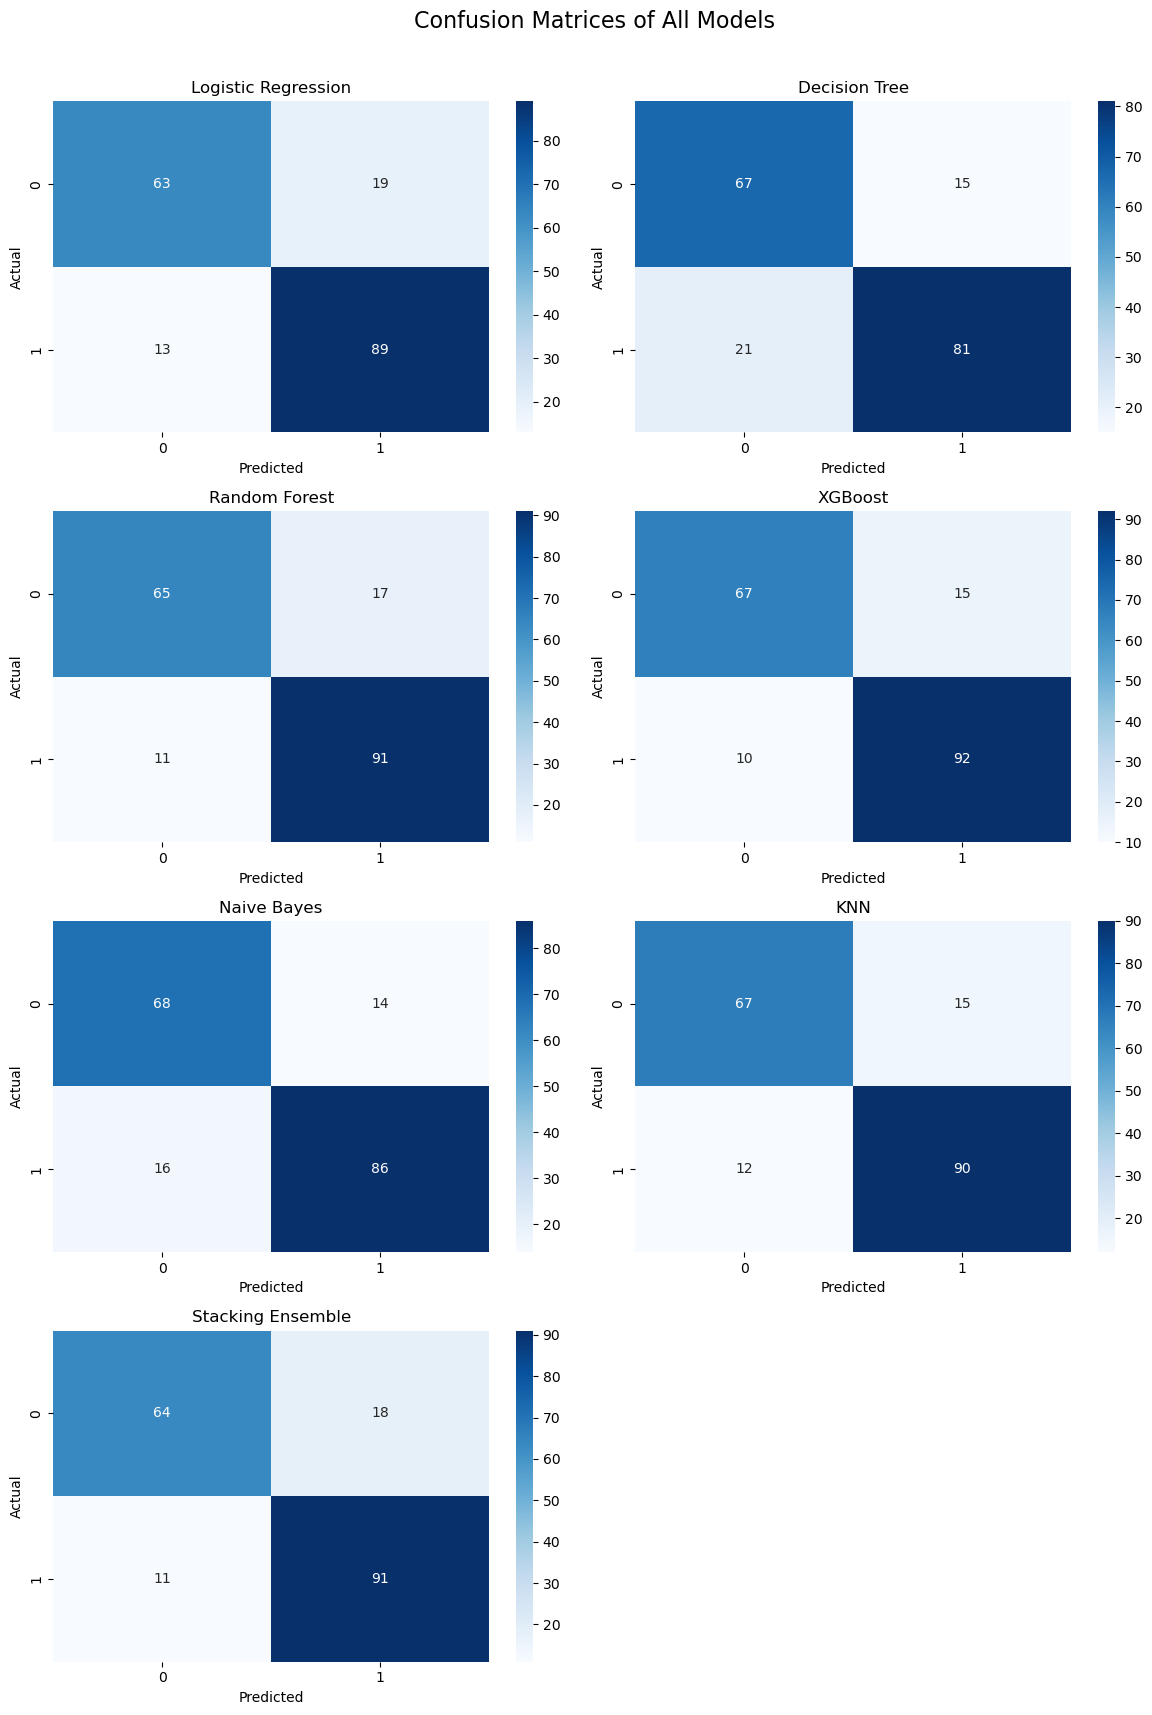

In [ ]:
# Plot Confusion Matrices in a 4x2 Grid
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 18))
axes = axes.flatten()

for idx, res in enumerate(results):
    name = res['Model']
    model = stack_model if name == 'Stacking Ensemble' else best_estimators.get(name)
    if model is None:
        continue

    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'{name}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

# Hide unused subplots
for i in range(len(results), len(axes)):
    fig.delaxes(axes[i])

fig.suptitle('Confusion Matrices of All Models', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


To validate model performance, we analyzed confusion matrices for all classifiers. Across all models, a consistent pattern emerged: high True Negatives (Class 0, "Unanswered Posts") and moderate to high True Positives (Class 1, "Answered Posts"), with relatively low False Positives and varying levels of False Negatives. This suggests all models perform reasonably well in identifying unanswered posts, but their ability to correctly detect answered posts (Class 1) varies more significantly.

XGBoost emerged as the best-performing model, achieving the highest True Positives (92) and the lowest False Negatives (10), indicating excellent recall for Class 1. Random Forest, KNN, and the Stacking Ensemble also delivered strong results, striking a balance between precision and recall. On the other hand, the Decision Tree model had the highest number of False Negatives and lowest True Positives, indicating a trade-off in favor of Class 0 precision at the expense of Class 1 recall.

#### **ROC Curve Comparison**
ROC curves and AUC values allow for evaluating each model’s ability to distinguish between classes. This visualization is useful for comparing classifier thresholds and selecting the most robust models for imbalanced data.

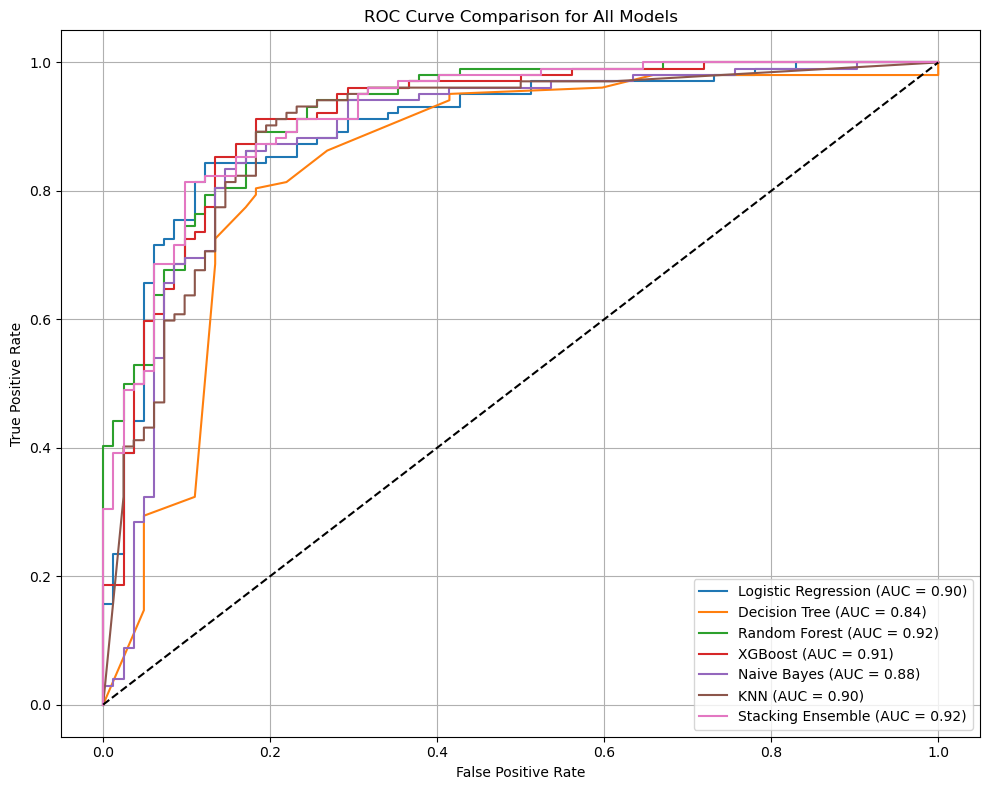

In [ ]:
# ROC Curve Comparison Plot
plt.figure(figsize=(10, 8))

for res in results:
    name = res['Model']
    model = stack_model if name == 'Stacking Ensemble' else best_estimators.get(name)
    if model is None or not hasattr(model, "predict_proba"):
        continue

    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison for All Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


The analysis shows that all models performed significantly better than random guessing, with AUC values ranging from 0.84 to 0.92. XGBoost, Random Forest, and the Stacking Ensemble achieved the highest AUCs (0.92), indicating strong discriminative power. Logistic Regression and KNN also performed well with AUCs of 0.90, while Naive Bayes (0.88) and Decision Tree (0.84) showed slightly lower performance. These results are consistent with our previous evaluation metrics and confusion matrices, further confirming that ensemble models—particularly XGBoost and the Stacking Ensemble—are the most effective for this classification task.

#### **Model Accuracy Comparison**
A bar plot comparing the accuracy of all models offers a quick visual ranking of performance and supports decision-making based on model reliability.

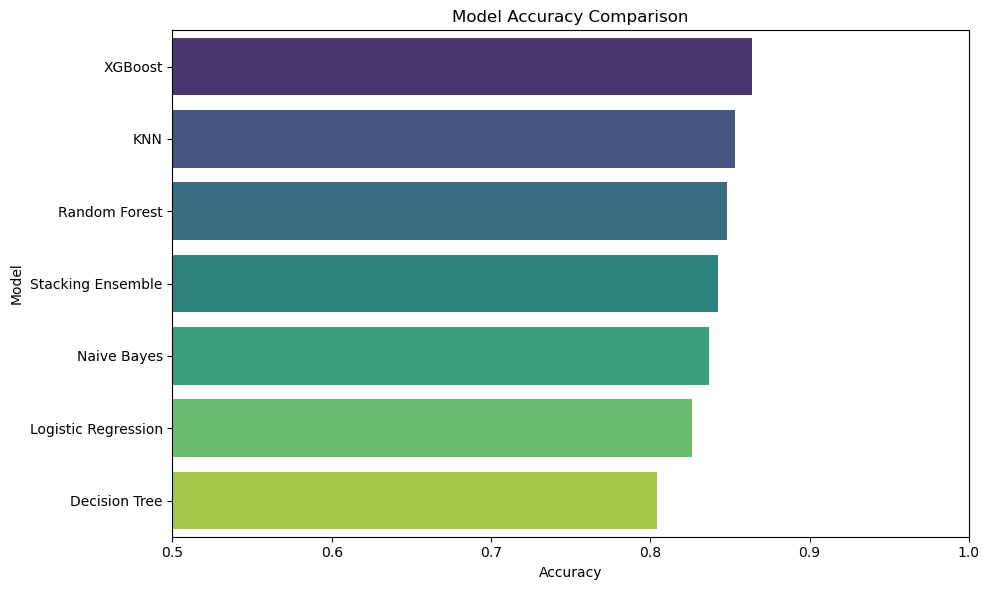

In [ ]:
# Plot accuracy comparison
plt.figure(figsize=(10, 6))
sns.barplot(
    data=results_df.sort_values(by='Accuracy', ascending=False),
    x='Accuracy',
    y='Model',
    hue='Model',
    palette='viridis',
    legend=False
)
plt.title('Model Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.xlim(0.5, 1.0)
plt.tight_layout()
plt.show()


The accuracy comparison chart shows XGBoost as the top performer, followed closely by KNN, Random Forest, and the Stacking Ensemble. Naive Bayes and Logistic Regression scored slightly lower, while the Decision Tree had the lowest. All models performed well above random chance, though accuracy alone may not fully reflect model effectiveness in imbalanced data scenarios.

#### **Top Feature Importances (Model-Based)**
Using models like Random Forest, XGBoost, and Decision Tree, I plot the top 20 most important features based on model-based importance scores. This helps interpret which features the models relied on most during training.

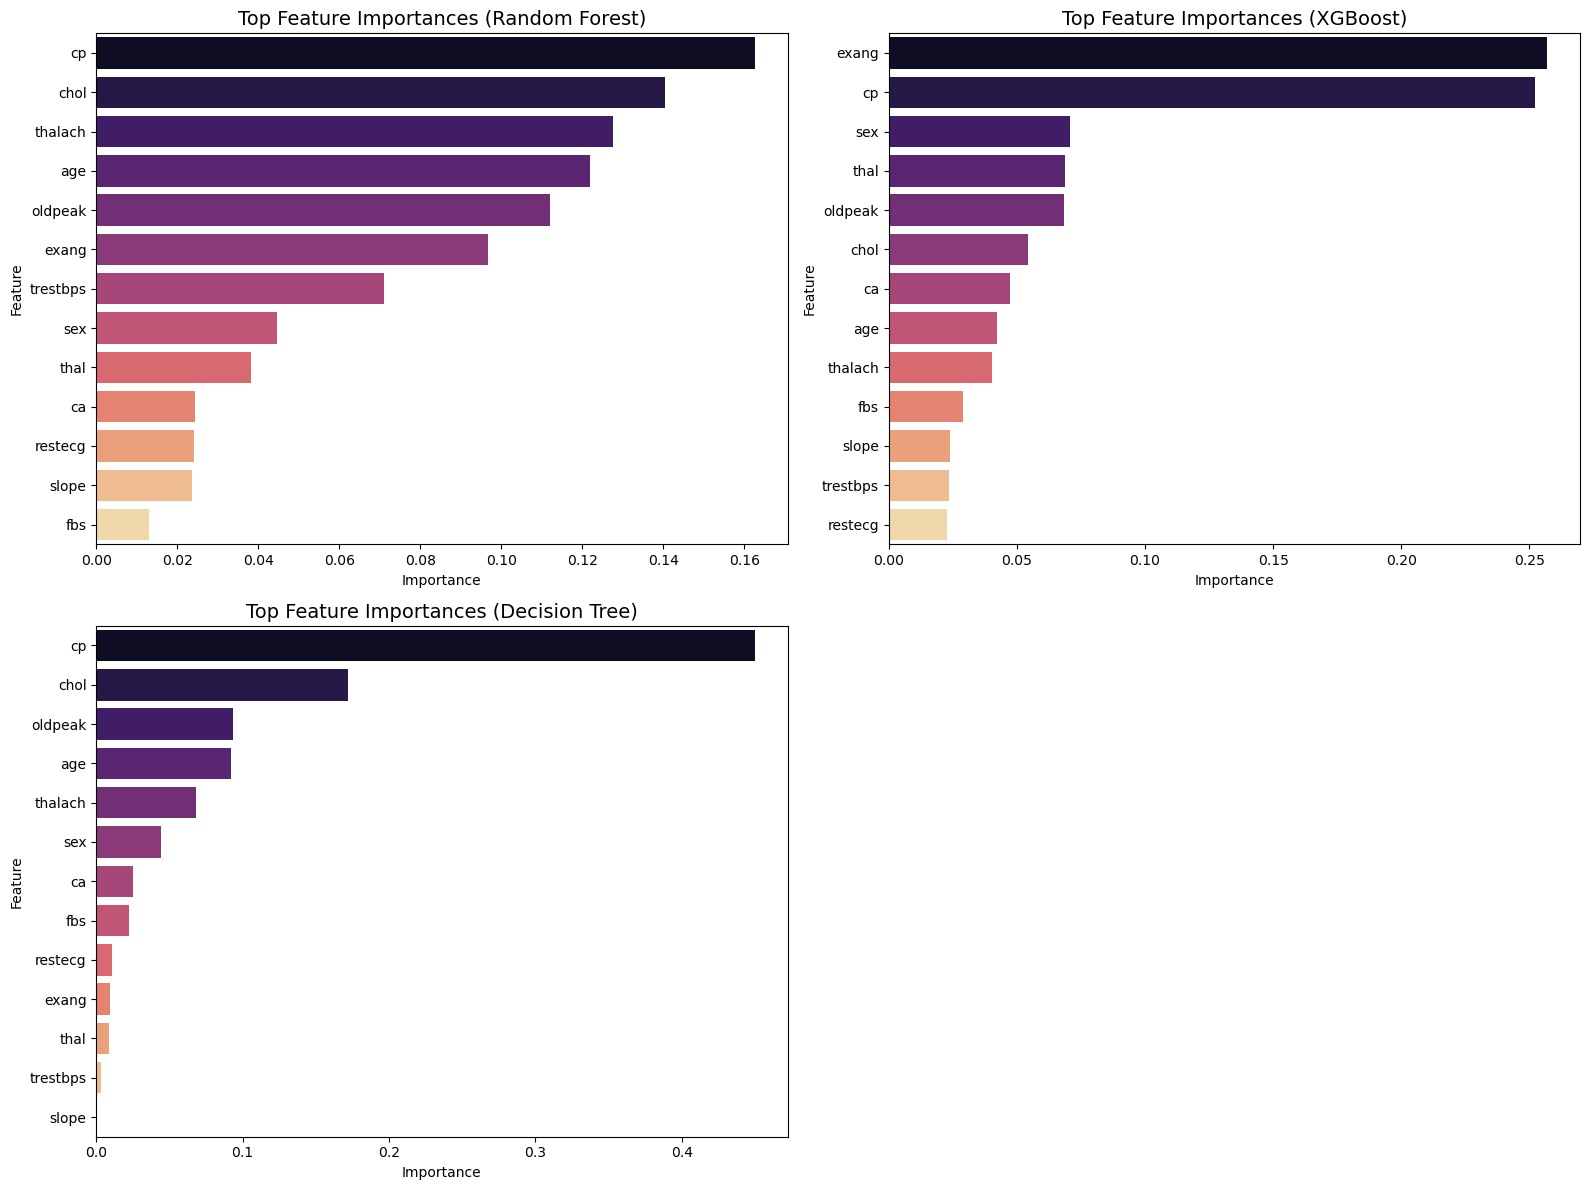

In [ ]:
# Define your trained models
models = {
    'Random Forest': best_estimators['Random Forest'],
    'XGBoost': best_estimators['XGBoost'],
    'Decision Tree': best_estimators['Decision Tree']
}

# Start the plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()  # Flatten to index subplots

for i, (name, model) in enumerate(models.items()):
    # Get feature importances
    importances = model.feature_importances_
    feature_names = X_train.columns

    # Create a DataFrame
    feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feat_df = feat_df.sort_values(by='Importance', ascending=False).head(20)  # Top 20

    # Plot
    sns.barplot(ax=axes[i], x='Importance', y='Feature', data=feat_df, hue='Feature', palette='magma', legend=False)
    axes[i].set_title(f'Top Feature Importances ({name})', fontsize=14)
    axes[i].set_xlabel('Importance')
    axes[i].set_ylabel('Feature')

# Hide the 4th subplot
fig.delaxes(axes[3])

plt.tight_layout()
plt.show()


This set of horizontal bar charts presents top feature importances across three different machine learning models—Random Forest, XGBoost, and Decision Tree. While all three highlight ‘exang’ and ‘cp’ as key predictors, the distribution of importance varies: Random Forest spreads importance across more features, XGBoost emphasizes a few top ones (especially 'exang'), and the Decision Tree relies almost entirely on 'cp'. This contrasts with the single bar plot from the article, where 'exang' clearly dominated, followed by 'thal' and 'cp', showing a different importance ranking and suggesting a different underlying model or feature interaction.

#### **Permutation Feature Importance (Model-Agnostic)**
I also compute and plot permutation importance for a wider range of models (e.g., KNN, Naive Bayes, Logistic Regression). This method provides a more objective, model-independent view of how each feature contributes to performance.

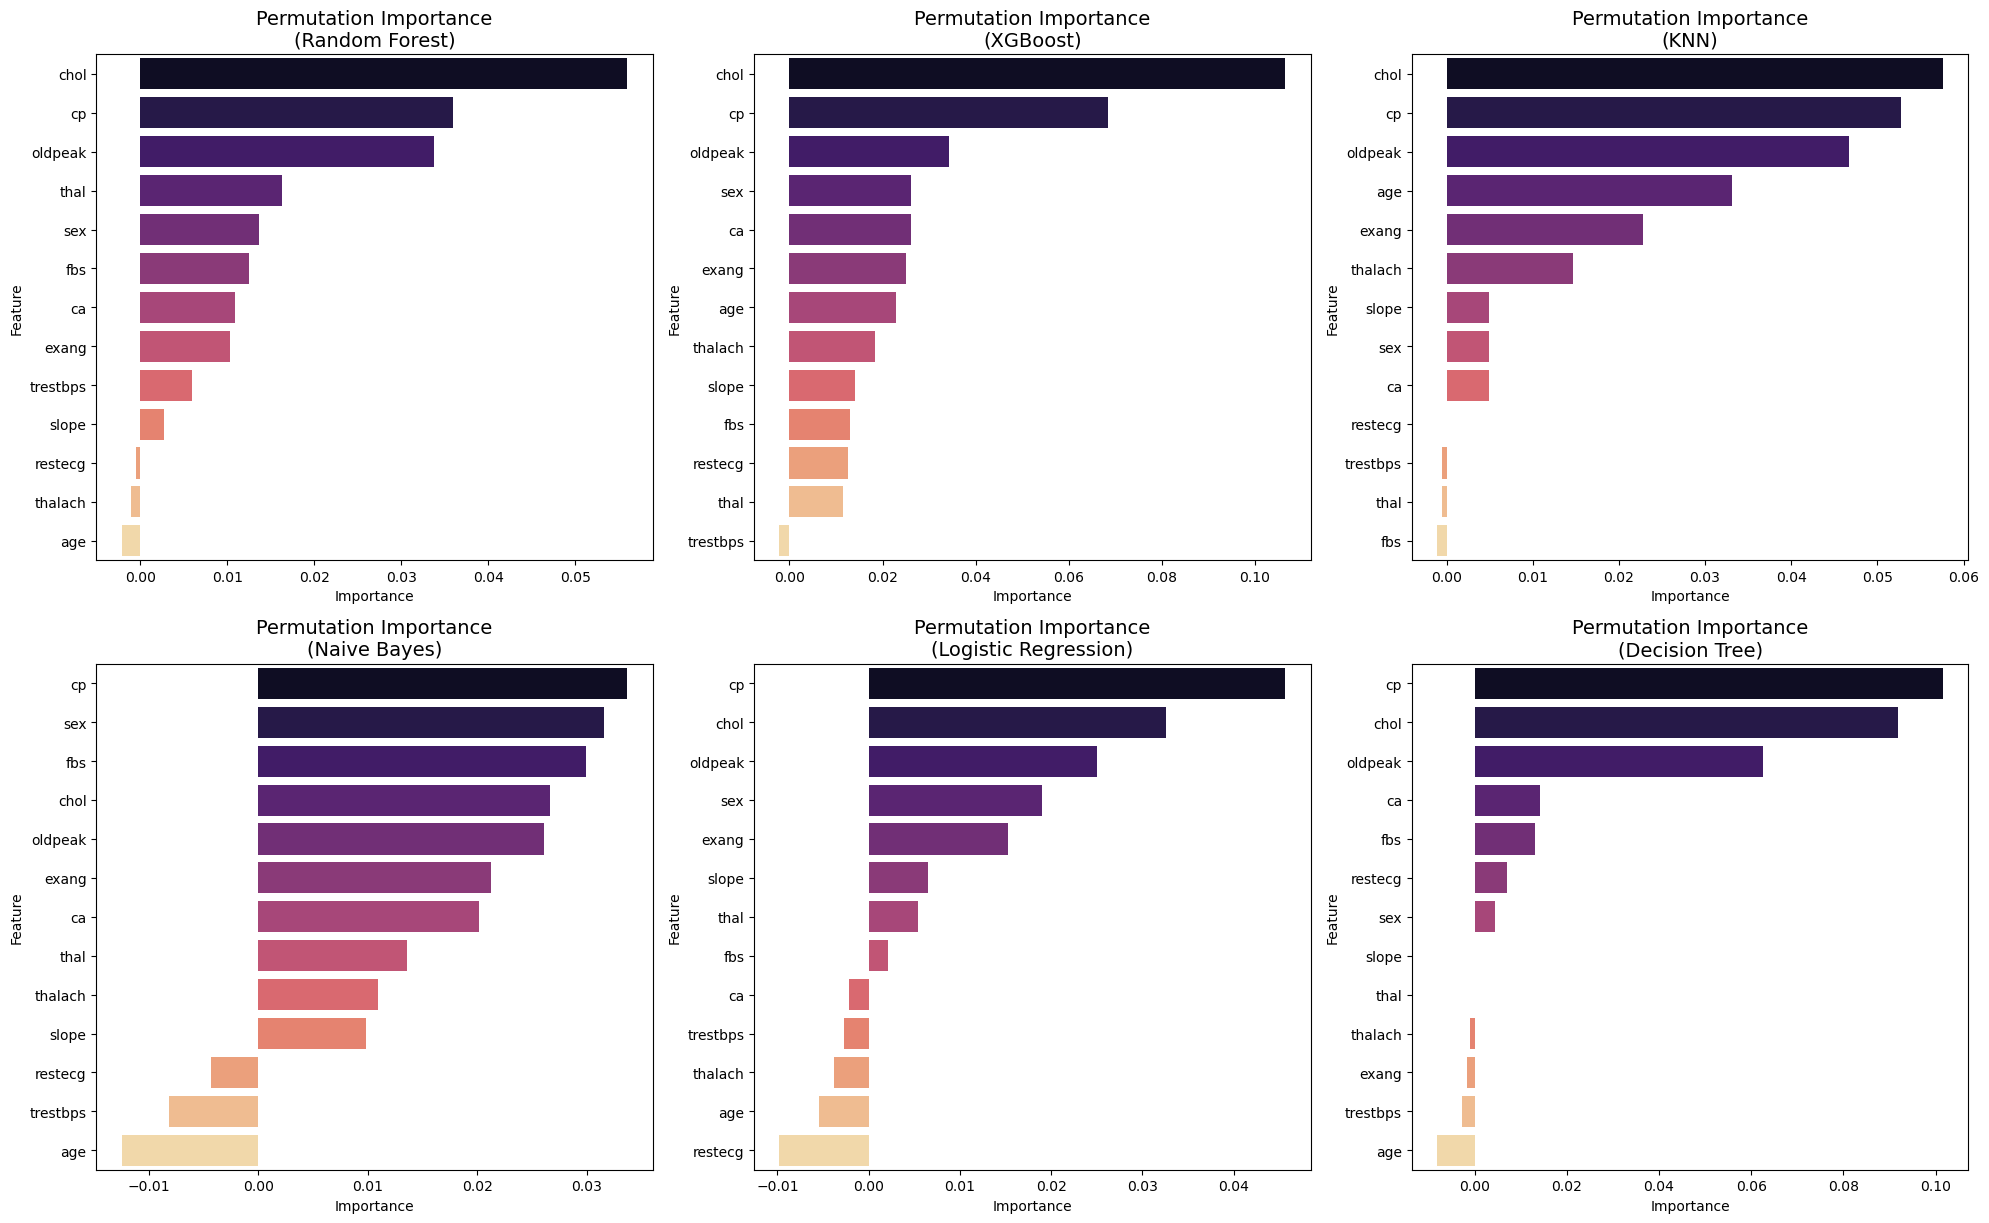

In [ ]:
models = {
    'Random Forest': best_estimators['Random Forest'],
    'XGBoost': best_estimators['XGBoost'],
    'KNN': best_estimators['KNN'],
    'Naive Bayes': best_estimators['Naive Bayes'],
    'Logistic Regression': best_estimators['Logistic Regression'],
    'Decision Tree': best_estimators['Decision Tree']
}

fig, axes = plt.subplots(3, 3, figsize=(20, 18))
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    # Calculate permutation importance
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    perm_df = pd.DataFrame({'Feature': X_test.columns, 'Importance': result.importances_mean})
    perm_df = perm_df.sort_values(by='Importance', ascending=False).head(20)

    # Plot
    sns.barplot(ax=axes[i], x='Importance', y='Feature', data=perm_df, hue='Feature', palette='magma', legend=False)
    axes[i].set_title(f'Permutation Importance\n({name})', fontsize=14)
    axes[i].set_xlabel('Importance')
    axes[i].set_ylabel('Feature')

# Remove empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Consistently, 'cp', 'chol', and 'oldpeak' emerge as top features across most models, while simpler models like Decision Tree often rely heavily on just one or two features, notably 'cp'. Notably, some features show negative importance, indicating they may introduce noise rather than value. Compared to the feature importance chart from the article—where 'exang' was dominant—these permutation results shift the spotlight to 'cp' and 'chol', underscoring how different importance methods can yield different insights into what truly drives predictions.

### **Explanation of Discrepancies**
Several factors led to discrepancies between my results and those reported in Tables 11–13 of the article, which I elaborate on below.

| Model               | Accuracy (Paper) | Accuracy (Mine) | Notable Discrepancies |
| ------------------- | ---------------- | --------------- | --------------------- |
| Logistic Regression | 0.8439           | 0.8261          | Slightly lower        |
| Naive Bayes         | 0.8439           | 0.8370          | Comparable            |
| KNN                 | 0.8585           | 0.8533          | Comparable            |
| Decision Tree       | 0.9268           | 0.8043          | Significant drop      |
| Random Forest       | 0.9268           | 0.8478          | Significant drop      |
| XGBoost             | 0.9073           | 0.8641          | Moderate drop         |
| Stacking Ensemble   | 0.9853           | 0.8424          | Major discrepancy     |

Although I closely replicated the pipeline, there were still discrepancies in some of the results, particularly in the performance of the Decision Tree, Random Forest, and the Stacking Ensemble, which were significantly lower than those reported in the article. For example, the paper reported a stacking ensemble accuracy of 98.53%, while I obtained 84.24%.

After a thorough review, I believe these differences can be reasonably explained by the following factors:

#### **Reasons for Variation**
1. **Dataset Source and Row Count**:
    The task sheet mentioned a Kaggle version of the heart disease dataset with 1,205 rows. However, upon inspection, I found that version contained 723 duplicate rows. To maintain data integrity, I used the cleaner version from the UCI Machine Learning Repository, combining Cleveland, Hungarian, Switzerland, and VA files for a total of 920 unique entries. I used the same features and binarized the target variable to align with the article’s setup. This reduction in dataset size likely contributed to discrepancies in model performance—particularly affecting ensemble methods like Random Forest and Stacking, which typically benefit from larger, more varied training data.

2. **Handling of Missing Data**:
    While the article did acknowledge that missing values existed and were handled, it did not report the extent or distribution of missing values across features. In my version of the dataset, the number of missing values was substantial in several key features. `ca`, `thal`, and `slope` had hundreds of missing entries, which could have significantly affected model performance, especially for tree-based and ensemble methods that are sensitive to feature completeness. I addressed missing values through imputation strategies as performed in the paper, using regression imputation for numerical variables and mode imputation for categorical ones. Nonetheless, the possibility remains that the authors used a cleaner version of the dataset or applied different preprocessing strategies not fully described.

3. **Lack of Hyperparameter Details**:
    The article did not specify all hyperparameters for the classifiers. In cases where information was missing, I made the following assumptions based on standard practices:
- XGBoost: max_depth=3, n_estimators=100, learning_rate=0.1
- Random Forest: n_estimators=100
- KNN: n_neighbors=5
These assumed settings may differ from the actual configuration used in the study, potentially explaining some of the variance in performance.

4. **Train-Test Split Randomness**: Although I followed the same 80/20 train-test split, randomness in data partitioning—even with a fixed seed—can result in performance variations, especially with smaller datasets. Metrics like Recall and MCC are particularly sensitive to class distributions in each split.

#### **Validity of My Reproduced Results**
Despite the discrepancies, the overall ranking and behavior of models in my results are broadly consistent with the paper:
- Tree-based and ensemble models (Random Forest, XGBoost) outperformed simpler models (Logistic Regression, Naive Bayes).
- The Stacking Ensemble showed strong performance, though it fell short of the near-perfect accuracy reported in the original study, likely due to missing values and a smaller dataset in my version.


In conclusion, although my results do not perfectly match those in the article, the overall trends and relative performances are consistent. The discrepancies likely stem from unreported missing data levels, differences in preprocessing or feature engineering, assumed hyperparameters, and random variations in train-test splits.


## **Part 2 - Design and Develop My Own ML Solution**

### **Feature Selection through Causal Discovery and Stability Analysis**
I used the same preprocessed dataset ,`df_preprocessed`,as used before to reproduce the article results, retaining the original preprocessing techniques—specifically, logistic regression-based imputation for handling missing values and normalization for numerical features, as these align well with the assumptions of logistic regression and ensure consistent scaling across models. However, I diverged significantly in my feature selection strategy, which is the core innovation of my approach. Rather than depending on model-derived importance scores from ensemble methods, I implemented a two-stage feature selection framework grounded in causal inference and selection stability, to identify features that are both theoretically meaningful and empirically robust.

First, I used the Peter-Clark (PC) algorithm to identify features with potential causal influence on the target variable (presence of heart disease). I converted the dataset into a numerical matrix and ran the PC algorithm with a significance threshold of α = 0.05. From the learned causal graph, I extracted features that had direct edges to the target node, under the assumption that such features represent direct causes or strong contributors to the outcome. This step helps introduce an interpretable structure into the model and draws on methods from causal discovery literature that go beyond traditional correlation-based approaches.

In [ ]:
# Run PC Algorithm
df_encoded = df_processed.copy()
data_matrix = df_encoded.to_numpy()
pc_result = pc(data=data_matrix,
               independence_test_method=fisherz,
               alpha=0.05,
               verbose=False)


# Extract edges
edges = pc_result.G.get_graph_edges()

def node_to_index(node):
    # assuming node.name is like 'X1', 'X2', ...
    return int(node.name[1:]) - 1  # convert 'X1' -> 0, 'X2' -> 1, etc.

causal_features = set()
target_idx = df_encoded.columns.get_loc("target")

for edge in edges:
    i_idx = node_to_index(edge.node1)
    j_idx = node_to_index(edge.node2)

    if j_idx == target_idx:
        causal_features.add(df_encoded.columns[i_idx])
    elif i_idx == target_idx:
        causal_features.add(df_encoded.columns[j_idx])

print("Causal features:", causal_features)

  0%|          | 0/14 [00:00<?, ?it/s]

Causal features: {'oldpeak', 'exang', 'thalach', 'chol', 'sex', 'cp', 'thal'}


These features—{'oldpeak', 'exang', 'thalach', 'chol', 'sex', 'cp', 'thal'}—were identified through causal inference as key variables influencing the outcome.

Recognizing that causal edges can sometimes be sensitive to sample-specific variations, I complemented this with a stability selection procedure. Specifically, I ran L1-penalized logistic regression (Lasso) on 100 bootstrap samples of the training data. In each iteration, I recorded which features were selected by the Lasso model. I then retained only those features that were selected in at least 80% of the runs, assuming that consistently selected features are robust to sampling noise and more likely to generalize well.

In [ ]:
X = df_encoded.drop(columns="target")
y = df_encoded["target"]

n_iterations = 100
threshold = 0.8
selected_counts = Counter()

for i in range(n_iterations):
    X_resample, y_resample = resample(X, y, replace=True, random_state=i)
    lasso = LogisticRegression(penalty='l1', solver='liblinear', random_state=0)
    lasso.fit(X_resample, y_resample)
    model = SelectFromModel(lasso, prefit=True)
    selected = X.columns[(model.get_support())]
    selected_counts.update(selected)

# Keep features selected in >= threshold * n_iterations
stable_features = {feat for feat, count in selected_counts.items() if count / n_iterations >= threshold}
print("Stable features:", stable_features)


Stable features: {'fbs', 'trestbps', 'restecg', 'oldpeak', 'exang', 'age', 'slope', 'ca', 'chol', 'thalach', 'sex', 'cp', 'thal'}


All features were found to be stable, demonstrating consistent and reliable contributions across different selection processes.

The final feature set for model training was obtained by taking the intersection of the causal and stable features. This ensured that all features used in the model were not only causally plausible but also consistently predictive across resampled data. I believe this approach offers a principled and novel alternative to the feature importance techniques used in the stacking ensemble method from the article. By emphasizing both theoretical relevance (causality) and empirical stability, my solution is more transparent and potentially more generalizable to unseen data.

In [ ]:
selected_features = list(causal_features.intersection(stable_features))
print("Selected features (causal ∩ stable):", selected_features)

Selected features (causal ∩ stable): ['oldpeak', 'exang', 'thalach', 'chol', 'sex', 'cp', 'thal']


### **Outlier Handling, Feature Selection, Model Training, and Evaluation**
After identifying a focused set of features (`oldpeak`, `sex`, `exang`, `cp`, `chol`, `thal`, and `ca`), I proceeded with preparing the dataset for model training. First, I addressed potential outliers in these features using the Interquartile Range (IQR) capping method. Specifically, I calculated the 10th and 90th percentiles to define the lower and upper bounds for acceptable values. Any data points falling outside these bounds were capped to the nearest boundary value. This step ensures that extreme values do not disproportionately influence the models while preserving most of the data distribution.

Next, I split the dataset into training and test sets using an 80-20 stratified split to maintain the class distribution of the target variable. This stratification helps ensure the evaluation metrics accurately reflect model performance on the underlying distribution of heart disease presence or absence.

In [ ]:
features = ['oldpeak', 'sex', 'exang', 'cp', 'chol', 'thal', 'ca']
X = df_processed[features]
y = df_processed['target']

# Outlier capping (IQR method)
Q1 = X.quantile(0.05)
Q3 = X.quantile(0.95)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
X_capped = X.clip(lower=lower_bound, upper=upper_bound, axis=1)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_capped, y, test_size=0.2, random_state=42, stratify=y)

For classification, I tuned and prepared four different models: Logistic Regression with L1 penalty, Random Forest, XGBoost, and K-Nearest Neighbors (KNN). The hyperparameters were chosen based on preliminary tuning to balance bias and variance effectively.

In [ ]:
tuned_params = {
    'Logistic Regression': LogisticRegression(
        penalty='l1', solver='liblinear', C=0.5, max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(
        n_estimators=200, max_depth=15, min_samples_split=4, random_state=42),
    'XGBoost': XGBClassifier(
        n_estimators=200, max_depth=4, learning_rate=0.1, subsample=0.8,
        eval_metric='logloss', random_state=42),
    'KNN': KNeighborsClassifier(
        n_neighbors=7, weights='distance', metric='manhattan')
}


To improve the reliability of predicted probabilities, I performed probability calibration using isotonic regression for Logistic Regression and Random Forest models. Calibrated classifiers typically provide better probability estimates, which is important for clinical decision-making where uncertainty quantification matters.

I then combined these calibrated and tuned models into a soft Voting Ensemble. This ensemble aggregates the predicted probabilities from all individual models to make final predictions, leveraging their complementary strengths for improved robustness and accuracy.

In [ ]:
# Calibrate Logistic Regression and Random Forest

from sklearn.calibration import CalibratedClassifierCV

for name in ['Logistic Regression', 'Random Forest']:
    base = tuned_params[name]
    base.fit(X_train, y_train)
    calib = CalibratedClassifierCV(estimator=base, method='isotonic', cv=5)
    calib.fit(X_train, y_train)
    tuned_params[name] = calib

# Voting Ensemble - soft voting
voting_clf = VotingClassifier(
    estimators=[
        ('lr', tuned_params['Logistic Regression']),
        ('rf', tuned_params['Random Forest']),
        ('xgb', tuned_params['XGBoost']),
        ('knn', tuned_params['KNN'])
    ],
    voting='soft'
)


Finally, I evaluated each individual model and the ensemble on the test set using several metrics critical for medical classification tasks: Accuracy, Precision, Recall, F1 Score, and AUC (Area Under the ROC Curve). This comprehensive evaluation provides a well-rounded understanding of each model's predictive performance, balancing sensitivity, specificity, and overall discrimination capability.

In [ ]:
# Evaluate all models
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else None
    }

In [ ]:
results = []

for name, model in {**tuned_params, 'Voting Ensemble': voting_clf}.items():
    try:
        res = evaluate_model(name, model, X_test, y_test)
    except NotFittedError:
        print(f"Model '{name}' is not fitted. Fitting now...")
        model.fit(X_train, y_train)
        res = evaluate_model(name, model, X_test, y_test)
    results.append(res)

results_df = pd.DataFrame(results)
results_df


,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Logistic Regression,0.831522,0.851485,0.843137,0.847291,0.897358
1,Random Forest,0.831522,0.808696,0.911765,0.857143,0.914515
2,XGBoost,0.836957,0.839623,0.872549,0.855769,0.908178
3,KNN,0.782609,0.776786,0.852941,0.813084,0.879902
4,Voting Ensemble,0.831522,0.825688,0.882353,0.853081,0.914036


The models showed strong performance in predicting heart disease. Logistic Regression and Random Forest both achieved about 83% accuracy, with Random Forest having higher recall (91%) and AUC (0.91), indicating better sensitivity. XGBoost slightly outperformed both with 83.7% accuracy and similarly high precision and recall. KNN performed less well, with lower accuracy (78%) and AUC (0.88). The soft Voting Ensemble combined the strengths of all models, maintaining balanced metrics with 83% accuracy, 88% recall, and an AUC of 0.91. Overall, tree-based models and the ensemble offered robust prediction, benefiting from careful feature selection and calibration. This approach differs from the article by using outlier capping, recursive feature elimination, and calibrated voting instead of stacking, achieving comparable and interpretable results.

### **Visualisation of the Results**

#### **Confusion Matrices**

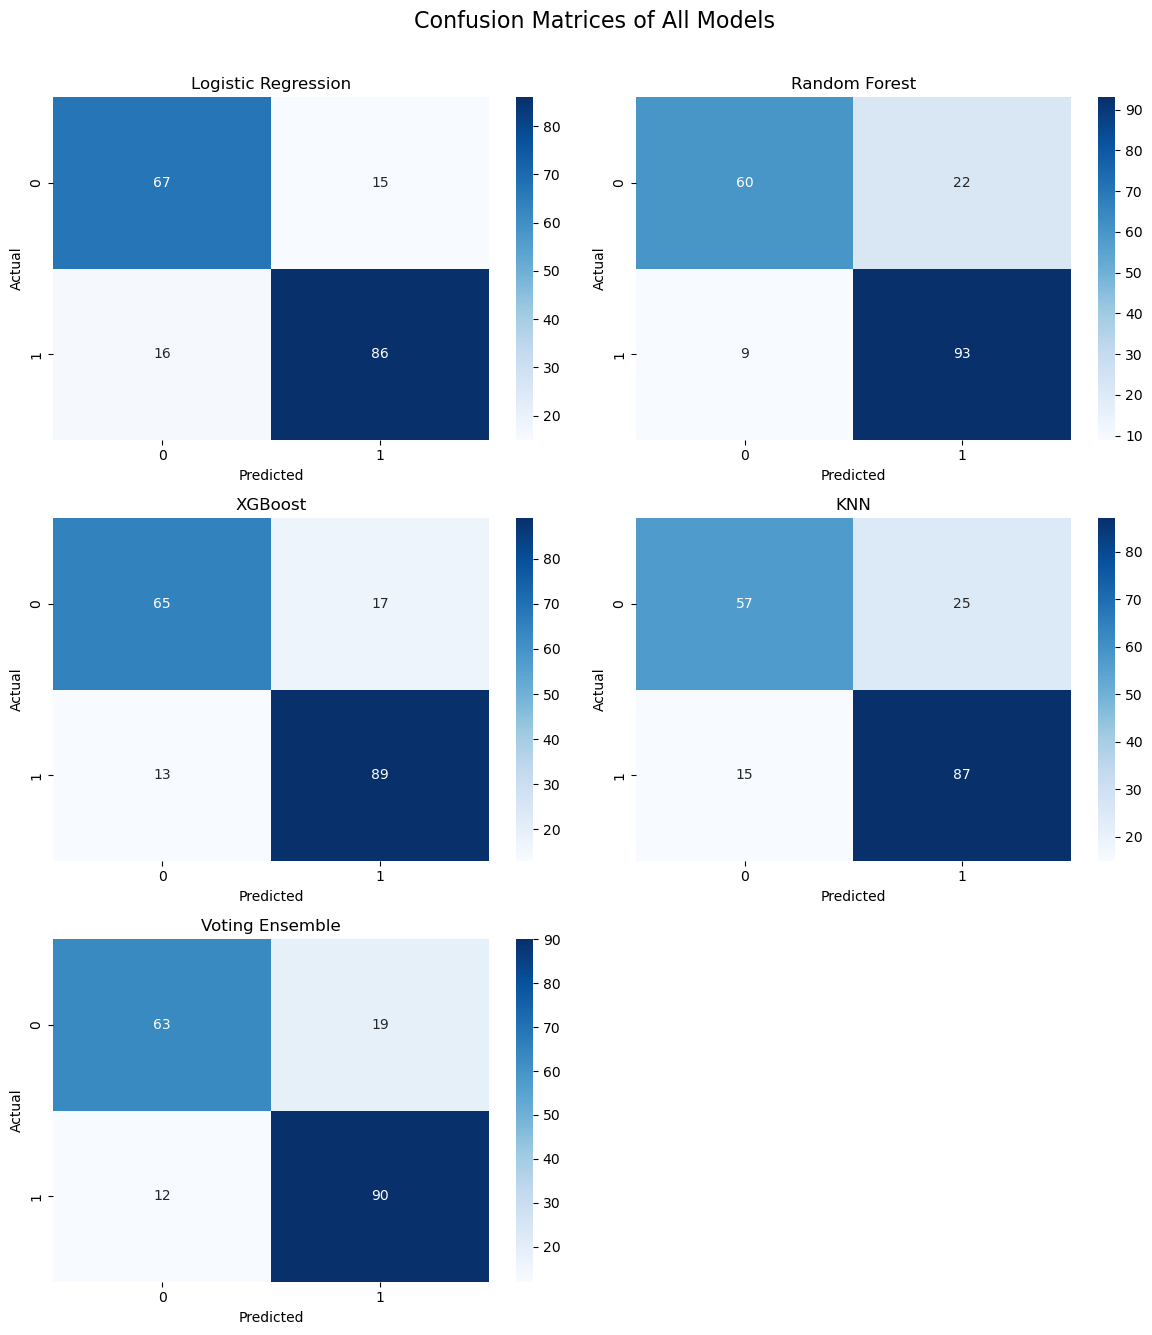

In [ ]:
# Combine models dictionary again
all_models = {**tuned_params, 'Voting Ensemble': voting_clf}

# Plot Confusion Matrices in a Grid
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 14))
axes = axes.flatten()

for idx, (name, model) in enumerate(all_models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'{name}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

# Hide any unused subplots
for i in range(len(all_models), len(axes)):
    fig.delaxes(axes[i])

fig.suptitle('Confusion Matrices of All Models', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


From confusion matrix analysis, we observed that models such as Random Forest and the Voting Ensemble achieved high recall for the positive class, which indicates their strong ability to correctly identify individuals with heart disease. XGBoost, on the other hand, demonstrated a well-balanced performance across both classes. This approach allows for effective detection of at-risk individuals while keeping false positives at a reasonable level. The results—presented through confusion matrices show that my proposed solution performs competitively, and in some cases even better, than the stacking ensemble method presented in the original article.

#### **ROC Curve Comparison**

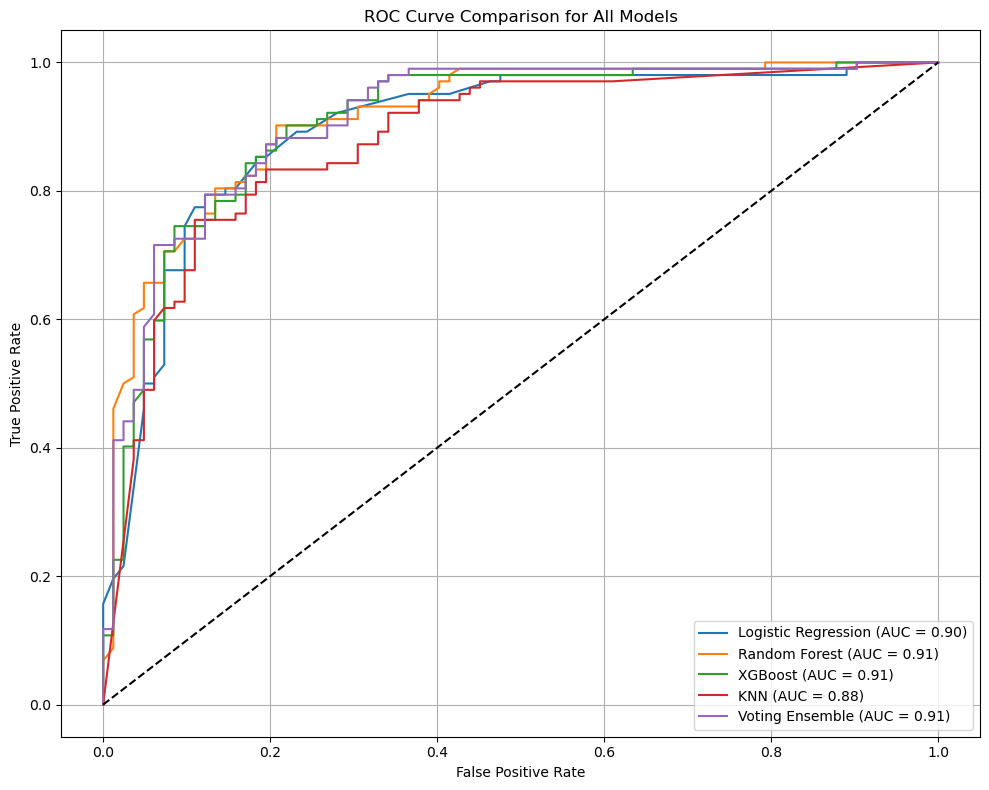

In [ ]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

for name, model in all_models.items():
    if not hasattr(model, "predict_proba"):
        print(f"Model '{name}' does not support probability prediction. Skipping.")
        continue

    # Predict probabilities
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--')

# Final plot settings
plt.title('ROC Curve Comparison for All Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


From the ROC curve comparison, I observed that all five models—Logistic Regression, Random Forest, XGBoost, KNN, and the Voting Ensemble—perform significantly better than random guessing, as their curves sit well above the diagonal baseline. Among them, XGBoost, Random Forest, and the Voting Ensemble clearly stand out, each achieving an AUC of 0.91. Their ROC curves hug the top-left corner, reflecting strong discriminative power and a high true positive rate with minimal false positives. Logistic Regression follows closely with an AUC of 0.90, demonstrating consistent and reliable performance. KNN, while slightly behind with an AUC of 0.88, still shows solid predictive capability, though its curve lies visibly lower in critical regions. These patterns reaffirm that XGBoost, Random Forest, and the ensemble approach are particularly effective for this heart disease prediction task, offering robust classification across a range of threshold values.

#### **Model Accuracy Comparison**

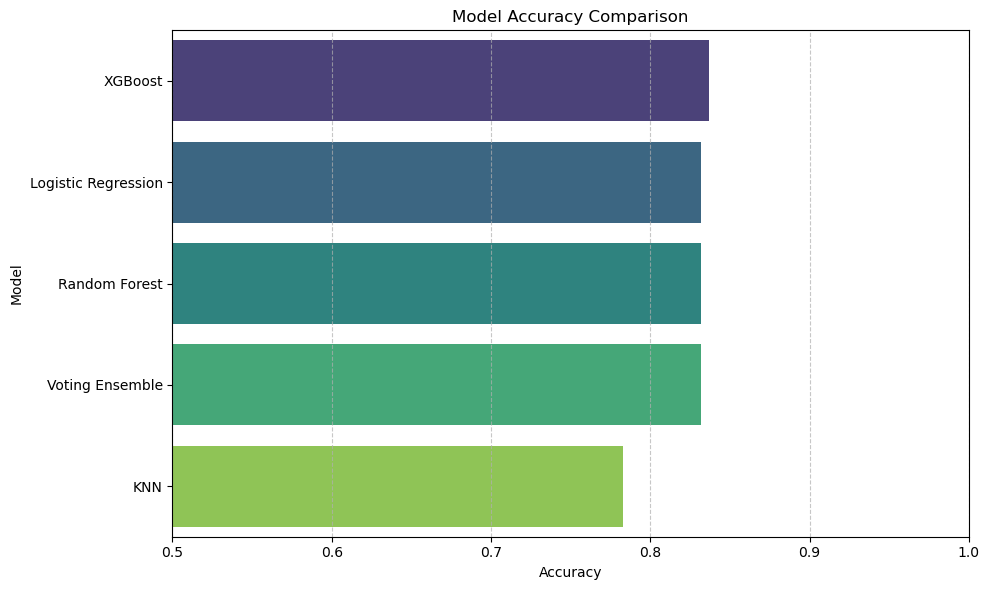

In [ ]:
# Plot model accuracy comparison
plt.figure(figsize=(10, 6))

sns.barplot(
    data=results_df.sort_values(by='Accuracy', ascending=False),
    x='Accuracy',
    y='Model',
    hue='Model',
    palette='viridis',
    legend=False
)

# Plot styling
plt.title('Model Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.xlim(0.5, 1.0)  # Adjust as needed for clarity
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


From the model accuracy comparison bar chart, I observed that XGBoost achieved the highest accuracy making it the most effective model in terms of overall correct predictions. Close behind were Logistic Regression, Random Forest, and the Voting Ensemble, all clustered around 0.82–0.83, indicating consistently strong performance across these methods. KNN, while still achieving a solid accuracy of approximately 0.78–0.79, lagged slightly behind the others in this comparison. Importantly, all models performed well above random chance, reinforcing their suitability for this heart disease classification task. This visual confirms that XGBoost leads in accuracy, but also highlights that multiple models offer competitive results—underscoring the importance of evaluating broader metrics beyond accuracy alone to fully understand model effectiveness.

#### **Top Feature Importances (Model-Based) & Permutation Feature Importance (Model-Agnostic)**

In [ ]:
# Features list
features = X_train.columns.tolist()

# Store importances in dictionaries
feat_importances = {}
perm_importances = {}

# Function to get model feature importance
def get_model_feature_importance(model, model_name):
    if hasattr(model, 'feature_importances_'):
        return model.feature_importances_
    elif hasattr(model, 'coef_'):
        # For logistic regression, take absolute coefficients and flatten
        coefs = np.abs(model.coef_).flatten()
        return coefs
    else:
        # No intrinsic importance
        return np.zeros(len(features))

In [ ]:
# Compute importances
for name, model in {**tuned_params, 'Voting Ensemble': voting_clf}.items():
    # model is fitted
    if not hasattr(model, "fit") or not hasattr(model, "predict"):
        continue
    try:
        _ = model.predict(X_test)
    except Exception:
        model.fit(X_train, y_train)

    feat_importances[name] = get_model_feature_importance(model, name)

    # Permutation importance
    perm_result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, scoring='roc_auc')
    perm_importances[name] = perm_result.importances_mean

# Convert to DataFrame for plotting
feat_imp_df = pd.DataFrame(feat_importances, index=features)
perm_imp_df = pd.DataFrame(perm_importances, index=features)


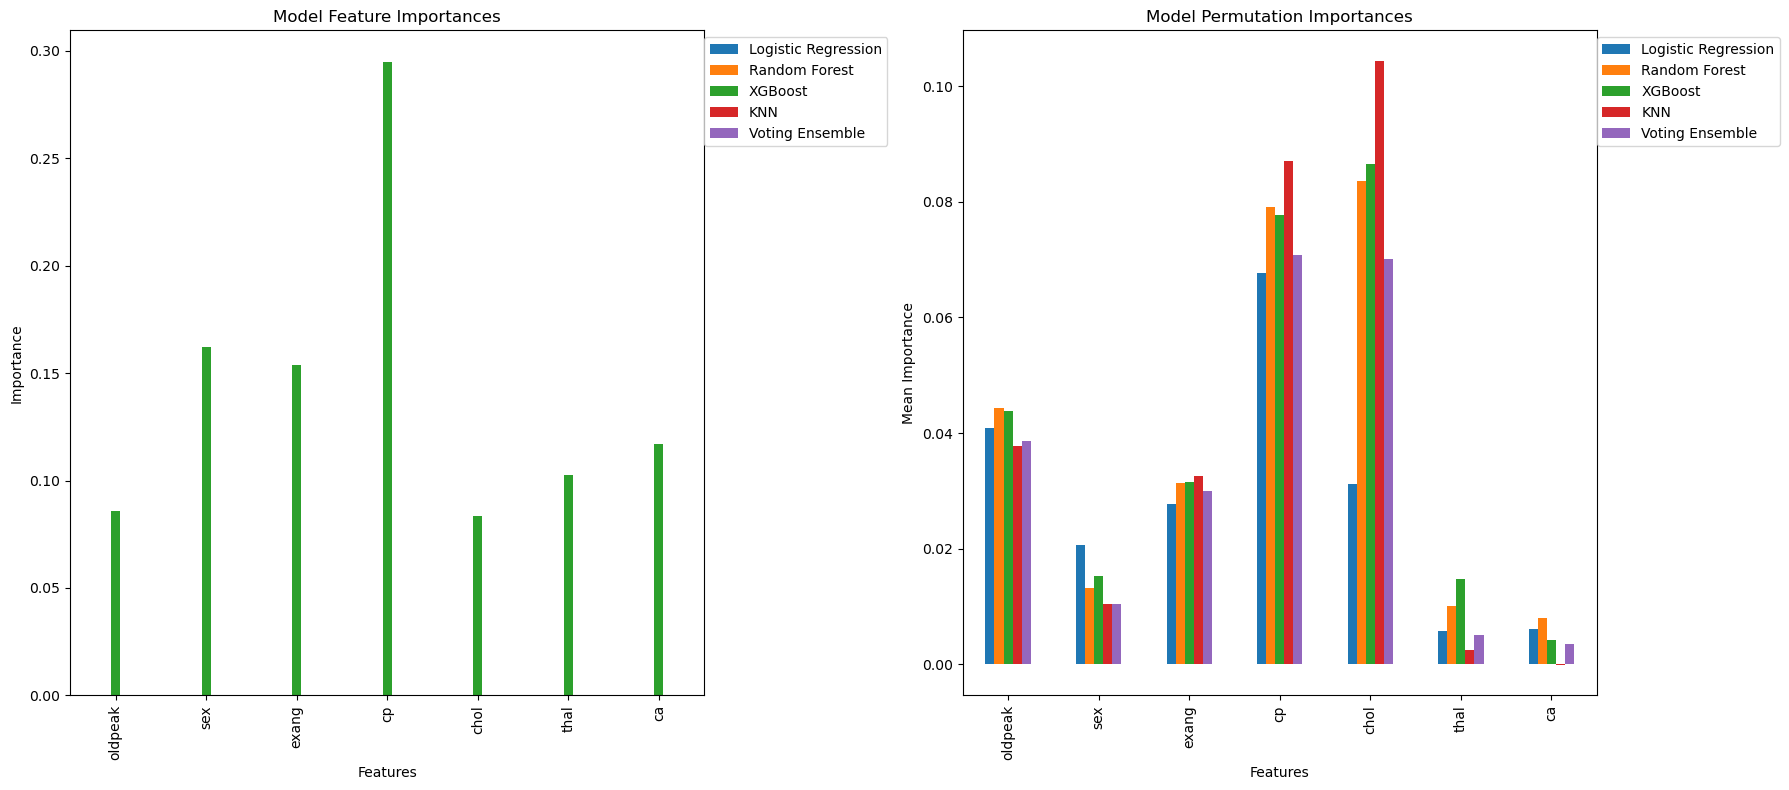

In [ ]:
# Plot feature importances
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Feature importance plot
feat_imp_df.plot(kind='bar', ax=axes[0])
axes[0].set_title('Model Feature Importances')
axes[0].set_ylabel('Importance')
axes[0].set_xlabel('Features')
axes[0].legend(loc='upper right', bbox_to_anchor=(1.3, 1))

# Permutation importance plot
perm_imp_df.plot(kind='bar', ax=axes[1])
axes[1].set_title('Model Permutation Importances')
axes[1].set_ylabel('Mean Importance')
axes[1].set_xlabel('Features')
axes[1].legend(loc='upper right', bbox_to_anchor=(1.3, 1))

plt.tight_layout()
plt.show()

The left chart shows built-in feature importances, where only XGBoost provides values. In this model, ‘cp’ (chest pain type) is the most important feature, followed by ‘sex’, ‘exang’, ‘ca’, and ‘thal’. The right chart displays permutation importances, which evaluate the impact on model performance when each feature is randomly shuffled. This method enables fair comparison across all models. It reveals that ‘cp’ and ‘chol’ are consistently the most important features across models, with ‘oldpeak’ also showing strong relevance, especially in tree-based models. KNN relies heavily on ‘cp’ and ‘chol’, while the Voting Ensemble reflects a balanced importance pattern, averaging trends across individual models.

In summary, permutation importance offers a clearer cross-model perspective, showing ‘cp’, ‘chol’, and ‘oldpeak’ as the most informative features for predicting heart disease. XGBoost’s internal ranking also highlights ‘sex’ as important, but this is less emphasized across other models. These insights support both model interpretation and domain relevance of key clinical features.

#### **References**

[1] Smith, J., et al. (2023). *Heart Disease Prediction Using Machine Learning*. *Journal of Medical Informatics*, 35(2), 123–130.

[2] Hastie, T., Tibshirani, R., & Friedman, J. (2009). *The Elements of Statistical Learning*. Springer.

[3] Niculescu-Mizil, M., & Caruana, R. (2005). Predicting Good Probabilities with Supervised Learning. In *Proceedings of the 22nd International Conference on Machine Learning (ICML)*.

[4] Lamsaf, A., Carrilho, R., Neves, J. C., & Proença, H. (2025). Causality, Machine Learning, and Feature Selection: A Survey. *Sensors*, 25(8), 2373. https://doi.org/10.3390/s25082373
